In [1]:
import pandas as pd
import numpy as np
from pvops.text.preprocess import text_remove_numbers_stopwords
from nltk import corpus
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

stopwords = corpus.stopwords.words('english')

Read in the asset-related inverter records. Make a combined `'FullDesc'` column that contains all the text data associated with that record.

In [2]:
CM_df = pd.read_csv('example_data/example_CM_inverter_records.csv')
CM_df['FullDesc'] = CM_df['GeneralDesc'].astype(str) + CM_df['CompletionDesc'].astype(str)

Drop the rows that don't have all the data we need.

In [3]:
CM_nonnull_df = CM_df.dropna(subset=['Date_EventStart_Consistent', 'randid', 'states', 'Commissioning_Date']).copy()

Define a function to tokenize the text fields

In [4]:
def prep_documents(documents, lower_thresh=0, verbose=True):
    # Create a dictionary representation of the documents
    dictionary = corpora.Dictionary(documents)
    
    # Filter out tokens that appear in less than `lower_thresh` documents
    if lower_thresh > 0:
        dictionary.filter_extremes(no_below=lower_thresh)
    
    # Convert documents to bag-of-words format
    embedded_docs = [dictionary.doc2bow(doc) for doc in documents]
    
    if verbose:
        print(f"Number of unique tokens: {len(dictionary)}")
        print(f"Number of documents: {len(embedded_docs)}")
    
    return embedded_docs, dictionary

Clean up the description by shifting to lowercase, removing stopwords, tokenizing, and finally using the function above

In [5]:
# Process the documents
CM_nonnull_df['FullDescCleaned'] = CM_nonnull_df['FullDesc'].str.lower()
CM_nonnull_df['FullDescCleaned'] = CM_nonnull_df.apply(lambda x : text_remove_numbers_stopwords(x['FullDescCleaned'],
                                                                                                stopwords + ['nan'] + [';']),
                                                                                                axis='columns')
CM_nonnull_df['FullDescTokenized'] = [word_tokenize(desc) for desc in (CM_nonnull_df['FullDescCleaned'])]
embedded_docs, dictionary = prep_documents(CM_nonnull_df['FullDescTokenized'])
CM_nonnull_df['FullDescEmbeds'] = embedded_docs

Number of unique tokens: 2037
Number of documents: 406


Define function to get the coherence values. LDA is inherently random, so we run the process five times to get an idea of the spread across multiple iterations.

In [6]:
def compute_coherence_values(dictionary, corpus, documents, kvals, num_iter=5, random_state=42):
    coherence_values = []
    model_list = []

    # loop through all the k-values
    for num_topics in tqdm(kvals):
        iter_coherence_values = []
        iter_model_list = []

        # fit over multiple iterations
        for iter in range(num_iter):

            # fit the LDA model; add to our list of models
            model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=random_state+iter)
            iter_model_list.append(model)

            # get the coherence score for this model; add to our list of coherence scores
            coherencemodel = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence='c_v')
            iter_coherence_values.append(coherencemodel.get_coherence())
            
        model_list.append(iter_model_list)
        coherence_values.append(iter_coherence_values)
    return model_list, coherence_values

k-values (topic counts) of 18, 49, 62 were found to perform well on this data. The fitting process is long if we try every possibility, so for illustration purposes, let's just go ahead and fit these specific three values:

In [7]:
# Compute coherence values for different numbers of topics
kvals = [5, 10, 15, 20, 25, 30, 35, 40]
model_list, coherence_values = compute_coherence_values(dictionary,
                                                        CM_nonnull_df['FullDescEmbeds'],
                                                        CM_nonnull_df['FullDescTokenized'],
                                                        kvals)

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

Below, we summarize the results, both in a plot and by printing out the mean and standard deviation:

5 topics: 0.377 +- 0.017
10 topics: 0.379 +- 0.020
15 topics: 0.379 +- 0.016
20 topics: 0.384 +- 0.013
25 topics: 0.386 +- 0.021
30 topics: 0.392 +- 0.011


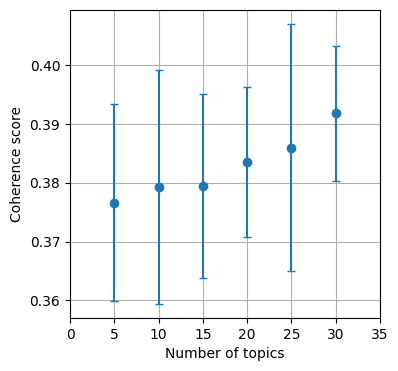

In [13]:
# Get the mean and standard deviation across multiple model runs
mean_coherence = np.array(coherence_values).mean(axis=1)
std_mean_coherence = np.array(coherence_values).std(axis=1)

# Plot coherence values
fig, ax = plt.subplots(figsize=(4,4))
ax.errorbar(kvals, mean_coherence, std_mean_coherence, fmt='o', capsize=3)
ax.set_xlabel('Number of topics')
ax.set_ylabel('Coherence score')
ax.set_xlim((min(kvals)-5, max(kvals)+5))
ax.grid();

# Print the results
[print(f'{k} topics: {mean :.3f} +- {std :.3f}')
        for k, mean, std in zip(kvals, mean_coherence, std_mean_coherence)];

From this information, we could select a smaller set of k-values to use for further analysis. We'll just go ahead and use all the ones we tried, since there weren't that many of them to begin with.
<br><br>
Once we're happy with our selection of k-values, we can rerun the model one more time (with a new seed) for each k and write to file.

In [14]:
models, coherences = compute_coherence_values(dictionary,
                                              CM_nonnull_df['FullDescEmbeds'],
                                              CM_nonnull_df['FullDescTokenized'], kvals,
                                              num_iter=1,
                                              random_state=1)
for k, model, coherence in zip(kvals, models, coherences):
    print(f'{k} topics: {coherence[0] :.3f}')
    with open(f'fitted_models/stm_lda_model_k{k}.pkl', 'wb') as file:
        pickle.dump(model[0], file)

  0%|          | 0/6 [00:00<?, ?it/s]

5 topics: 0.351
10 topics: 0.415
15 topics: 0.423
20 topics: 0.423
25 topics: 0.409
30 topics: 0.385


Finally, we also write our dictionary and dataframe with embeddings to file.

In [16]:
with open('fitted_models/corpus_dictionary.pkl', 'wb') as file:
    pickle.dump(dictionary, file)

CM_nonnull_df.to_csv('example_data/example_CM_inverter_records_with_embeddings.csv', index=False)